In [2]:
# if you're running local, comment the code below
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:

!pip install numpy==1.25.0



In [3]:

%cd /content/drive/MyDrive/DL4M/SipSync

/content/drive/.shortcut-targets-by-id/1ezncdvjSUPgnhtviWIB7cpiejrOQEtdZ/SipSync


In [4]:
%pip install mirdata keras-tcn

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.0
    Uninstalling numpy-1.25.0:
      Successfully uninstalled numpy-1.25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [5]:
%load_ext autoreload
%autoreload 2


In [6]:
import warnings

# Fix the random seed for reproducibility
from numpy.random import seed
seed(124)

import tensorflow as tf
import keras
tf.keras.utils.set_random_seed(124)


In [7]:
import sys
import os

# Append the directory containing utils1.py to the system path
sys.path.append('/content/drive/MyDrive/DL4M/SipSync')

import mirdata
import utils as u


In [42]:
data_home = '/content/drive/MyDrive/DL4M/SipSync/mir_datasets/'
dataset = mirdata.initialize('mtg_jamendo_autotagging_moodtheme', data_home=data_home)
dataset.download(cleanup=True, force_overwrite=True)

# data_home = '/content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios'
# dataset = mirdata.initialize('mtg_jamendo_autotagging_moodtheme', data_home=data_home)
# dataset.download(cleanup=True, force_overwrite=True)


33.3MB [00:04, 7.37MB/s]                            
2.30MB [00:04, 503kB/s]                            


In [43]:
data_home

'/content/drive/MyDrive/DL4M/SipSync/mir_datasets/'

In [44]:
import os

available_tracks = {}

for track_id, track in dataset.load_tracks().items():
    if os.path.exists(track.audio_path):
        available_tracks[track_id] = track

print(f"Found {len(available_tracks)} available tracks with audio.")

Found 2175 available tracks with audio.


In [45]:
# selected_tags = ['mood/theme---happy', 'mood/theme---positive', 'mood/theme---love', 'mood/theme---romantic', 'mood/theme---energetic', 'mood/theme---party', 'mood/theme---relaxing', 'mood/theme---calm', 'mood/theme---sad', 'mood/theme---melancholic', 'mood/theme---dark', 'mood/theme---heavy', 'mood/theme---dream', 'mood/theme---space', 'mood/theme---inspiring', 'mood/theme---hopeful']
# selected_tags = ['mood/theme---happy', 'mood/theme---positive', 'mood/theme---love', 'mood/theme---romantic', 'mood/theme---energetic', 'mood/theme---party', 'mood/theme---relaxing', 'mood/theme---calm', 'mood/theme---sad', 'mood/theme---melancholic']
selected_tags = ['mood/theme---happy', 'mood/theme---positive', 'mood/theme---love', 'mood/theme---romantic', 'mood/theme---energetic', 'mood/theme---party', 'mood/theme---relaxing', 'mood/theme---calm']



# Filter to only available tracks (those with an existing audio file)
available_tracks = {
    track_id: track for track_id, track in dataset.load_tracks().items()
    if os.path.exists(track.audio_path)
    and track.tags in selected_tags
}

# Now choose a random one from the available tracks
import random

if available_tracks:
    track_id = random.choice(list(available_tracks.keys()))
    track = available_tracks[track_id]

    print("Track ID:", track_id)
    print("Audio path:", track.audio_path)
    print("Audio tuple (waveform, sr):", track.audio)

else:
    print("No available audio files found.")

Track ID: track_1312109
Audio path: /content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/09/1312109.mp3
Audio tuple (waveform, sr): (array([-0.00726203, -0.00232804,  0.01092713, ..., -0.07663842,
       -0.07252022, -0.05844115], dtype=float32), 22050)


In [46]:
n_mels = 128
hop_size = 512
spectrogram = u.compute_mel_spectrogram(track.audio[0], track.audio[1], n_mels, hop_size)

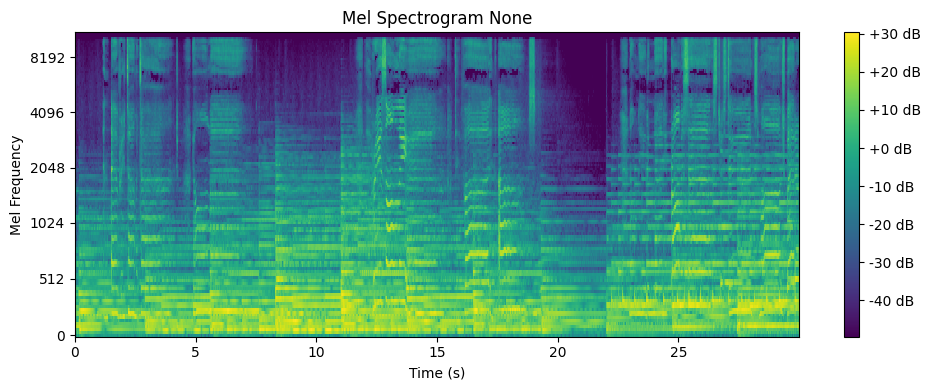

In [47]:
u.plot_spectrogram(spectrogram, track.audio[1], hop_size)

In [48]:
import IPython
IPython.display.Audio(track.audio[0], rate=track.audio[1])

In [49]:
# from sklearn.model_selection import train_test_split

# track_ids = dataset.track_ids

# train_ids, test_ids = train_test_split(track_ids, test_size=0.2, random_state=124)
# train_ids, val_ids = train_test_split(train_ids, test_size=0.25, random_state=124)

# print(f"Number of Tracks in Training Set: {len(train_ids)}")
# print(f"Number of Tracks in Validation Set: {len(val_ids)}")
# print(f"Number of Tracks in Test Set: {len(test_ids)}")




from sklearn.model_selection import train_test_split

# track_ids = dataset.track_ids

## track_ids = [track.split('_')[1] for track in list(available_tracks.keys())]
track_ids = list(available_tracks.keys())

train_ids, test_ids = train_test_split(track_ids, test_size=0.2, random_state=124)
train_ids, val_ids = train_test_split(train_ids, test_size=0.25, random_state=124)

print(f"Number of Tracks in Training Set: {len(train_ids)}")
print(f"Number of Tracks in Validation Set: {len(val_ids)}")
print(f"Number of Tracks in Test Set: {len(test_ids)}")



Number of Tracks in Training Set: 272
Number of Tracks in Validation Set: 91
Number of Tracks in Test Set: 91


In [50]:

mood_mapping = {mood: i for i, mood in enumerate(selected_tags)}
mood_mapping



{'mood/theme---happy': 0,
 'mood/theme---positive': 1,
 'mood/theme---love': 2,
 'mood/theme---romantic': 3,
 'mood/theme---energetic': 4,
 'mood/theme---party': 5,
 'mood/theme---relaxing': 6,
 'mood/theme---calm': 7}

In [51]:
# def get_main_tag(tag_string):
#     return tag_string.split(",")[0] if tag_string else "unknown"

# split_data = dataset.get_track_splits(split_number=0)

# labels_train = [get_main_tag(dataset.track(tid).tags) for tid in split_data['train']]
# labels_val = [get_main_tag(dataset.track(tid).tags) for tid in split_data['validation']]
# labels_test = [get_main_tag(dataset.track(tid).tags) for tid in split_data['test']]






# def get_main_tag(tag_string):
#     return tag_string.split(",")[0] if tag_string else "unknown"

# split_data = dataset.get_track_splits(split_number=0)

# labels_train = [get_main_tag(dataset.track(tid).tags) for tid in split_data['train']]
# labels_val = [get_main_tag(dataset.track(tid).tags) for tid in split_data['validation']]
# labels_test = [get_main_tag(dataset.track(tid).tags) for tid in split_data['test']]






def get_main_tag(tag_string):
    return tag_string.split(",")[0] if tag_string else "unknown"

split_data = dataset.get_track_splits(split_number=0)

labels_train = [get_main_tag(dataset.track(tid).tags) for tid in split_data['train'] if tid in available_tracks.keys()]
labels_val = [get_main_tag(dataset.track(tid).tags) for tid in split_data['validation'] if tid in available_tracks.keys()]
labels_test = [get_main_tag(dataset.track(tid).tags) for tid in split_data['test'] if tid in available_tracks.keys()]



In [52]:

moods = mood_mapping.keys()

# for mood in labels_val:
#   if mood not in moods:
#     print(mood)

print(len(set(labels_train)))
print(len(set(labels_val)))
print(len(set(labels_test)))


8
8
8


In [53]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# # Get a frequency-based mapping of the most common moods
# all_moods = labels_train + labels_val + labels_test
# top_moods = [m for m, _ in Counter(all_moods).most_common(50)]  # top 15
# mood_mapping = {mood: i for i, mood in enumerate(top_moods)}

# mood_mapping = {mood: i for i, mood in enumerate(all_moods)}

In [54]:
len(mood_mapping.keys())

8

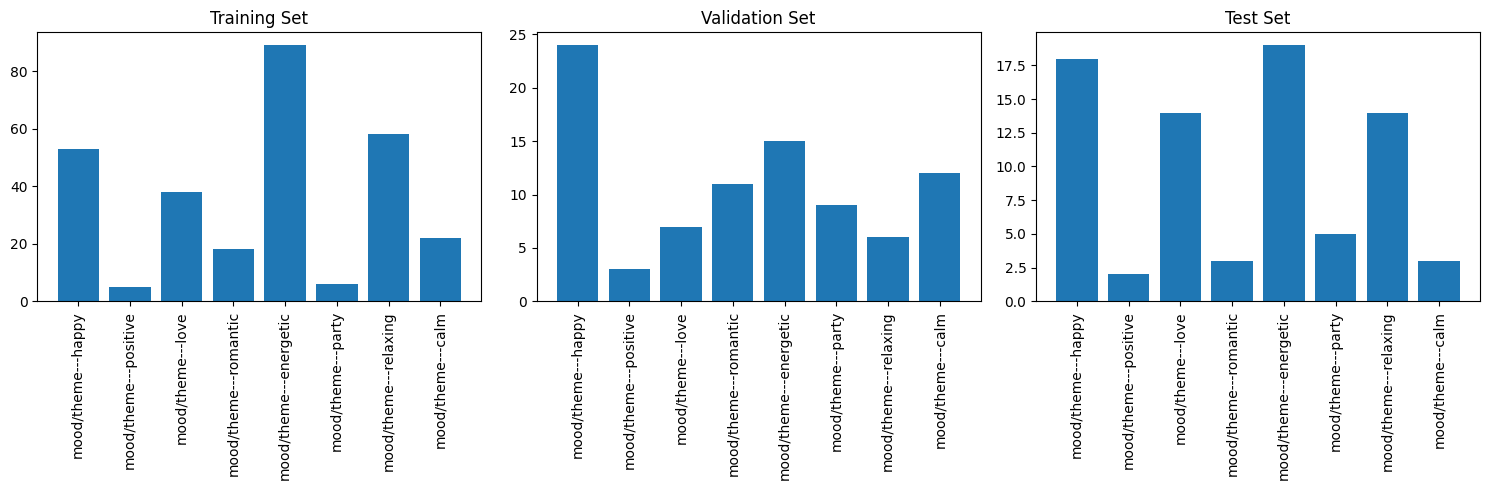

In [55]:
u.explore_data_mood(labels_train, labels_val, labels_test, mood_mapping)

In [56]:
audio_00 = os.listdir(data_home + 'audios' + '/00/')
audio_01 = os.listdir(data_home + 'audios' + '/01/')
audio_02 = os.listdir(data_home + 'audios' + '/02/')



In [57]:
all_track_paths = [track.audio_path for track_id, track in dataset.load_tracks().items()]

missing = []

for path in audio_00:
  if path not in all_track_paths:
    missing.append(path)

for path in audio_01:
  if path not in all_track_paths:
    missing.append(path)

for path in audio_02:
  if path not in all_track_paths:
    missing.append(path)


In [58]:
mood_weights ={}

for mood in mood_mapping.keys():
  try:
    mood_weights[mood_mapping[mood]] = len(labels_train)/labels_train.count(mood)
  except:
    mood_weights[mood_mapping[mood]] = 0

mood_weights


{0: 5.452830188679245,
 1: 57.8,
 2: 7.605263157894737,
 3: 16.055555555555557,
 4: 3.247191011235955,
 5: 48.166666666666664,
 6: 4.982758620689655,
 7: 13.136363636363637}

#consolidate data for test (Ivana ignore)

In [ ]:
import soundfile as sf
from IPython.display import display, Audio

path = '/content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/1002000.mp3'
signal, sr = sf.read(path)
sr

display(Audio(signal, rate=sr))

In [ ]:
import os

audio_path = '/content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/'
songs = os.listdir(audio_path)

songs

['1053500.mp3',
 '1054100.mp3',
 '1056400.mp3',
 '1060600.mp3',
 '1063200.mp3',
 '1060000.mp3',
 '1062500.mp3',
 '1062600.mp3',
 '1066200.mp3',
 '1066500.mp3',
 '1066800.mp3',
 '1069400.mp3',
 '1070600.mp3',
 '1069500.mp3',
 '1072900.mp3',
 '1073700.mp3',
 '1071300.mp3',
 '1075200.mp3',
 '1109900.mp3',
 '1076600.mp3',
 '1079300.mp3',
 '1080900.mp3',
 '1079400.mp3',
 '1112000.mp3',
 '1081000.mp3',
 '1083100.mp3',
 '1084200.mp3',
 '1085700.mp3',
 '1085600.mp3',
 '1086700.mp3',
 '1087100.mp3',
 '1088000.mp3',
 '1088100.mp3',
 '1089300.mp3',
 '1090200.mp3',
 '1090700.mp3',
 '1093500.mp3',
 '1095600.mp3',
 '1125400.mp3',
 '1096800.mp3',
 '1098500.mp3',
 '1100200.mp3',
 '1100.mp3',
 '1101300.mp3',
 '1102300.mp3',
 '1103000.mp3',
 '1103300.mp3',
 '1105300.mp3',
 '1105600.mp3',
 '11100.mp3',
 '1110000.mp3',
 '1110500.mp3',
 '1110300.mp3',
 '1114500.mp3',
 '1115100.mp3',
 '1115700.mp3',
 '1115400.mp3',
 '1116400.mp3',
 '111600.mp3',
 '1118600.mp3',
 '1123300.mp3',
 '1121400.mp3',
 '1119900.mp3'

In [ ]:
import librosa

def change_sample_rate(input_file, output_file, new_sample_rate):
    """
    Changes the sample rate of an audio file.

    Args:
        input_file (str): Path to the input audio file.
        output_file (str): Path to save the output audio file.
        new_sample_rate (int): The desired sample rate in Hz.
    """
    audio, original_sample_rate = librosa.load(input_file, sr=None)
    resampled_audio = librosa.resample(audio, orig_sr=original_sample_rate, target_sr=new_sample_rate)
    sf.write(output_file, resampled_audio, new_sample_rate)

for song in songs:

  song_path = audio_path + song
  new_sample_rate = 22050
  change_sample_rate(song_path, song_path, new_sample_rate)

  print(song_path)


/content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/1053500.mp3
/content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/1054100.mp3
/content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/1056400.mp3
/content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/1060600.mp3
/content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/1063200.mp3
/content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/1060000.mp3
/content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/1062500.mp3
/content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/1062600.mp3
/content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/1066200.mp3
/content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/1066500.mp3
/content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/1066800.mp3
/content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/1069400.mp3
/content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/1070600.mp3
/content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/1069500.mp3
/conte

In [ ]:
def test_copy(input_file, output_file):
    """
    Changes the sample rate of an audio file.

    Args:
        input_file (str): Path to the input audio file.
        output_file (str): Path to save the output audio file.
        new_sample_rate (int): The desired sample rate in Hz.
    """
    audio, sr = librosa.load(input_file, sr=None)
    audio = audio[:int(30 * sr)]

    # resampled_audio = librosa.resample(audio, orig_sr=original_sample_rate, target_sr=new_sample_rate)
    sf.write(output_file, audio, sr)

In [ ]:
for i in range(int(len(songs)/4)):
  song = songs[i]
  song_path = audio_path + song
  copy_path = f'/content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/{song}'
  test_copy(song_path, copy_path)

  print(f'{i}: {copy_path}')



0: /content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/1053500.mp3
1: /content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/1054100.mp3
2: /content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/1056400.mp3
3: /content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/1060600.mp3
4: /content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/1063200.mp3
5: /content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/1060000.mp3
6: /content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/1062500.mp3
7: /content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/1062600.mp3
8: /content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/1066200.mp3
9: /content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/1066500.mp3
10: /content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/1066800.mp3
11: /content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/1069400.mp3
12: /content/drive/MyDrive/DL4M/SipSync/mir_datasets/audios/00/1070600.mp3
13: /content/drive/MyDrive/DL4M/Sip

In [ ]:
int(len(songs)/4)

36

In [ ]:
all_tags = [track.tags for track_id, track in dataset.load_tracks().items()]

unique_tags = set(tags for tags in all_tags)

#selected_tracks = {track_id: track for track_id, track in dataset.load_tracks().items() if any(tag in track.tags for tag in used_tags)}


# train model

In [54]:

# Waveform
sample_rate = 22050

# Spectrogram
n_mels = 128
hop_length = 512
audio_seg_size = 1  # seconds: how big the input to the CNN will be
segments_overlap = audio_seg_size/2  # seconds: how much overlap between windows
stft_length = int(np.ceil(sample_rate*audio_seg_size/hop_length))  # samples: how many windows the STFT will have

# The CNN receives windows of spectrograms
input_shape = (n_mels, stft_length, 1)

# Augmentation
augment = False
pitch_shift_steps=2

input_args_train = [data_home, augment, train_ids, sample_rate, pitch_shift_steps,
                    n_mels, hop_length, audio_seg_size, segments_overlap, True] # Last arg is shuffle
input_args_val   = [data_home, augment, val_ids, sample_rate, pitch_shift_steps,
                    n_mels, hop_length, audio_seg_size, segments_overlap, True]
input_args_test  = [data_home, augment, test_ids, sample_rate, pitch_shift_steps,
                    n_mels, hop_length, audio_seg_size, segments_overlap, False]

dataset_train = u.create_dataset(u.win_generator, input_args_train, input_shape)
dataset_val = u.create_dataset(u.win_generator, input_args_val, input_shape)
dataset_test= u.create_dataset(u.win_generator, input_args_test, input_shape)



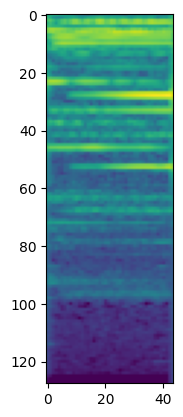

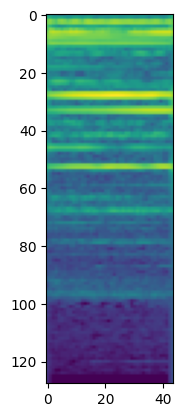

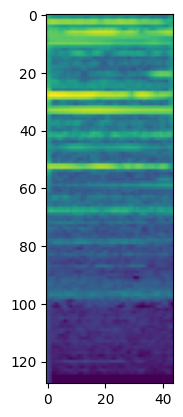

In [55]:
import matplotlib.pyplot as plt
# Look at the windows fit into the model
for sp, l in dataset_train.take(3):
    plt.imshow(sp)
    plt.show()

{0: 5.830188679245283,
 1: 61.8,
 2: 8.131578947368421,
 3: 17.166666666666668,
 4: 3.4719101123595504,
 5: 51.5,
 6: 5.327586206896552,
 7: 14.045454545454545,
 8: 28.09090909090909,
 9: 34.333333333333336}

In [57]:
len(train_ids)

305

In [58]:
from models import cnn_model

# Create a convolutional model
model = cnn_model(input_shape)

# Print model summary
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 42, 20)    │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 42, 42, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 42, 42, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 40, 40, 20)     │         3,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 40, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 13, 40, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 38, 20)     │         3,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 38, 20)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 3, 38, 20)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       145,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,032 (609.50 KB)

 Trainable params: 156,032 (609.50 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=f"checkpoints/audio_convnet.keras",
        save_best_only=True,
        monitor="val_loss")
]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # try to ignore AutoGraph warnings
    # Train the model
    history = model.fit(dataset_train.prefetch(tf.data.AUTOTUNE).batch(batch_size).cache(),
        validation_data=dataset_val.prefetch(tf.data.AUTOTUNE).batch(batch_size).cache(),
        epochs=10,
        callbacks=callbacks,
        # class_weight=mood_weights
    )




Epoch 1/10


KeyboardInterrupt: 

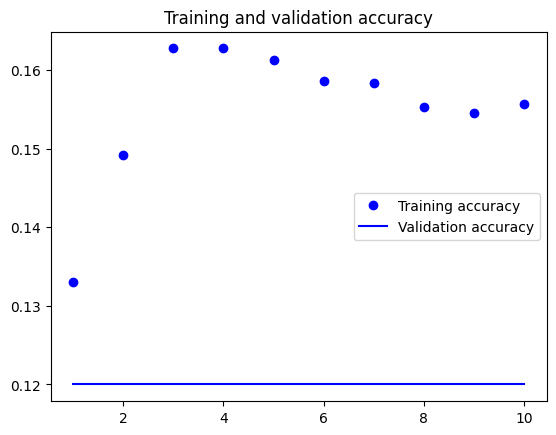

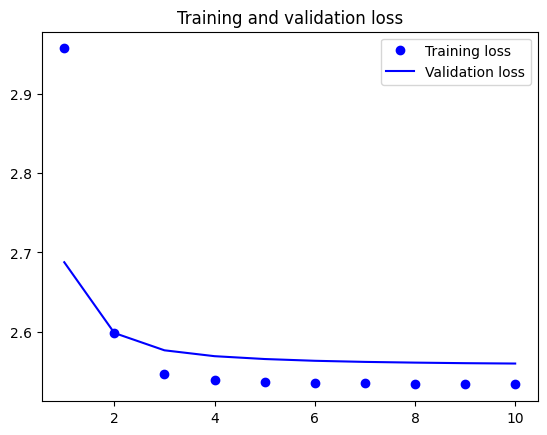

In [ ]:
u.plot_loss(history)

In [ ]:
# Load the best checkpoint of the model
model_reloaded = keras.models.load_model("checkpoints/audio_convnet.keras")

# Evaluate the model on the test set
test_loss, test_acc = model_reloaded.evaluate(dataset_test.prefetch(tf.data.AUTOTUNE).batch(batch_size))
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


136/136 ━━━━━━━━━━━━━━━━━━━━ 59s 427ms/step - accuracy: 0.0747 - loss: 2.6062
Test Loss: 2.5448, Test Accuracy: 0.0933


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


# YAMnet transfer learn

In [107]:
# Waveform
sample_rate = 16000  # 16kHz for YAMNet
augment = False
input_shape = (29*sample_rate,)

input_args_train = [data_home, augment, train_ids, sample_rate]
input_args_val   = [data_home, augment, val_ids, sample_rate]
input_args_test  = [data_home, augment, test_ids, sample_rate]

dataset_train = u.create_dataset(u.wav_generator, input_args_train, input_shape)
dataset_val = u.create_dataset(u.wav_generator, input_args_val, input_shape)
dataset_test= u.create_dataset(u.wav_generator, input_args_test, input_shape)

In [108]:
import tensorflow_hub as hub

yamnet = hub.load('https://tfhub.dev/google/yamnet/1')

In [109]:
from models import tcn_model

input_shape =  (60, 1024)
# Create a tcn model that processes the embeddings
tcn_yamnet = tcn_model(input_shape)

# Print model summary
tcn_yamnet.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn_11 (TCN)                    │ (None, 64)             │       619,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 619,848 (2.36 MB)

 Trainable params: 619,848 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

In [110]:
# Define a mapping function to extract embeddings
def map_function(audio, label):
   return u.extract_yamnet_embedding(audio, yamnet), label

# Check input shape from example in the data
for e, l in dataset_train.map(map_function).take(1):
    print(e.shape)

(60, 1024)


In [111]:
batch_size = 32
model_path = "checkpoints/yamnet_model.json"
model_weights = "checkpoints/yamnet.weights.h5"

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath=model_weights,
      save_best_only=True,
      save_weights_only=True,
      monitor="val_loss")
]

history = tcn_yamnet.fit(dataset_train.prefetch(tf.data.AUTOTUNE).map(map_function).batch(batch_size).cache(),
    validation_data=dataset_val.prefetch(tf.data.AUTOTUNE).map(map_function).batch(batch_size).cache(),
    epochs=10,
    class_weight=mood_weights,
    callbacks=callbacks)

model_as_json = tcn_yamnet.to_json()
with open(model_path, "w") as json_file:
    json_file.write(model_as_json)

Epoch 1/10
      9/Unknown 69s 6s/step - accuracy: 0.1180 - loss: 22.7329

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


9/9 ━━━━━━━━━━━━━━━━━━━━ 90s 8s/step - accuracy: 0.1205 - loss: 22.5833 - val_accuracy: 0.1648 - val_loss: 2.3694
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 58s 131ms/step - accuracy: 0.1973 - loss: 14.7900 - val_accuracy: 0.3187 - val_loss: 1.9699
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4337 - loss: 10.5090 - val_accuracy: 0.2967 - val_loss: 1.9132
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5970 - loss: 7.3233 - val_accuracy: 0.4066 - val_loss: 1.9745
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7176 - loss: 5.2566 - val_accuracy: 0.2637 - val_loss: 2.0847
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7501 - loss: 4.2380 - val_accuracy: 0.4505 - val_loss: 2.0700
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8433 - loss: 2.7424 - val_accuracy: 0.4505 - val_loss: 2.2596
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9347 - loss: 2.0258 - val_accuracy: 0.3956 - val_loss: 2.1830
Epoch 9

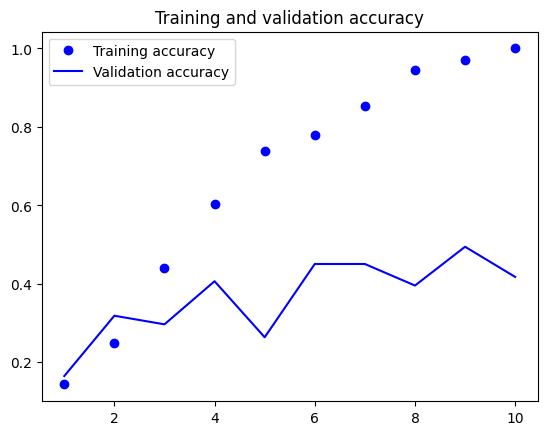

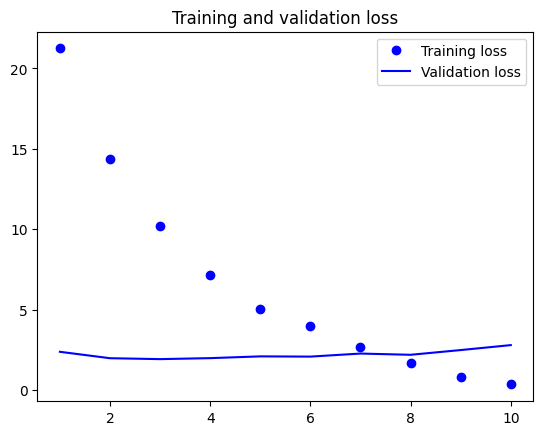

In [112]:
u.plot_loss(history)

In [113]:
# Load the best checkpoint of the model
optimizer = 'adam'
loss = 'sparse_categorical_crossentropy'
metrics = ["accuracy"]
tcn_yamnet_reloaded = u.reload_tcn(model_path, model_weights, optimizer, loss, metrics)

# Evaluate the model on the test set
test_loss_yamnet, test_acc_yamnet = tcn_yamnet_reloaded.evaluate(dataset_test.prefetch(tf.data.AUTOTUNE).map(map_function).batch(batch_size))
print(f"Test Loss: {test_loss_yamnet:.4f}, Test Accuracy: {test_acc_yamnet:.4f}")




/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 58 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step - accuracy: 0.3312 - loss: 1.7632
Test Loss: 1.7649, Test Accuracy: 0.3187


In [117]:



preds = tcn_yamnet_reloaded.predict(dataset_test.prefetch(tf.data.AUTOTUNE).map(map_function).batch(batch_size))


preds[0]



3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


array([0.15931979, 0.13615894, 0.10434454, 0.06761312, 0.06420275,
       0.04396604, 0.13925675, 0.28513807], dtype=float32)

# MusicFM Transfer Learning

In [66]:
!git clone https://github.com/minzwon/musicfm.git /content/drive/MyDrive/DL4M/SipSync/musicfm

fatal: destination path '/content/drive/MyDrive/DL4M/SipSync/musicfm' already exists and is not an empty directory.


In [67]:
!wget -P /content/drive/MyDrive/DL4M/SipSync/musicfm/data https://huggingface.co/minzwon/MusicFM/resolve/main/msd_stats.json
!wget -P /content/drive/MyDrive/DL4M/SipSync/musicfm/data https://huggingface.co/minzwon/MusicFM/resolve/main/pretrained_msd.pt

--2025-04-30 10:10:46--  https://huggingface.co/minzwon/MusicFM/resolve/main/msd_stats.json
Resolving huggingface.co (huggingface.co)... 13.35.202.121, 13.35.202.97, 13.35.202.34, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2277 (2.2K) [text/plain]
Saving to: ‘/content/drive/MyDrive/DL4M/SipSync/musicfm/data/msd_stats.json.2’

msd_stats.json.2    100%[===================>]   2.22K  --.-KB/s    in 0s      

2025-04-30 10:10:46 (446 MB/s) - ‘/content/drive/MyDrive/DL4M/SipSync/musicfm/data/msd_stats.json.2’ saved [2277/2277]

--2025-04-30 10:10:46--  https://huggingface.co/minzwon/MusicFM/resolve/main/pretrained_msd.pt
Resolving huggingface.co (huggingface.co)... 13.35.202.121, 13.35.202.97, 13.35.202.34, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.121|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/59/f9/59f9da2ff22

In [104]:

# Waveform
sample_rate = 16000  # 16kHz for YAMNet
augment = False
input_shape = (29*sample_rate,)

input_args_train = [data_home, augment, train_ids, sample_rate]
input_args_val   = [data_home, augment, val_ids, sample_rate]
input_args_test  = [data_home, augment, test_ids, sample_rate]

dataset_train = u.create_dataset(u.wav_generator, input_args_train, input_shape)
dataset_val = u.create_dataset(u.wav_generator, input_args_val, input_shape)
dataset_test= u.create_dataset(u.wav_generator, input_args_test, input_shape)



In [97]:
data_home

'/content/drive/MyDrive/DL4M/SipSync/mir_datasets/'

In [98]:
import os
import sys
import torch


musicfm_path = '/content/drive/MyDrive/DL4M/SipSync/'

sys.path.append(musicfm_path)
from musicfm.model.musicfm_25hz import MusicFM25Hz

# # dummy audio (30 seconds, 24kHz)
# wav = (torch.rand(4, 24000 * 30) - 0.5) * 2


# load MusicFM
musicfm = MusicFM25Hz(
    is_flash=False,
    stat_path=os.path.join(musicfm_path, "musicfm", "data", "msd_stats.json"),
    model_path=os.path.join(musicfm_path, "musicfm", "data", "pretrained_msd.pt"),
)

# # to GPUs
# wav = wav.cuda()
# musicfm = musicfm.cuda()

# # get embeddings
# musicfm.eval()
# emb = musicfm.get_latent(wav, layer_ix=7)




In [105]:
from models import tcn_model

input_shape =  (60, 1024)
# Create a tcn model that processes the embeddings
tcn_musicfm = tcn_model(input_shape)

# Print model summary
tcn_musicfm.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn_10 (TCN)                    │ (None, 64)             │       619,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 619,848 (2.36 MB)

 Trainable params: 619,848 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

In [106]:
# Define a mapping function to extract embeddings
def map_function(audio, label):
   return u.extract_musicfm_embedding(audio, musicfm), label

# Check input shape from example in the data
for e, l in dataset_train.map(map_function).take(1):
    print(e.shape)




<class 'tensorflow.python.framework.ops.SymbolicTensor'>


AttributeError: in user code:

    File "<ipython-input-75-947e548fa7cc>", line 3, in map_function  *
        return u.extract_musicfm_embedding(audio, musicfm), label
    File "/content/drive/.shortcut-targets-by-id/1ezncdvjSUPgnhtviWIB7cpiejrOQEtdZ/SipSync/utils.py", line 282, in extract_musicfm_embedding  *
        scores, embeddings, spectrogram = musicfm.get_latent(wav_data, layer_ix=7)
    File "/content/drive/.shortcut-targets-by-id/1ezncdvjSUPgnhtviWIB7cpiejrOQEtdZ/SipSync/musicfm/model/musicfm_25hz.py", line 222, in get_latent  *
        _, hidden_states = self.get_predictions(x)
    File "/content/drive/.shortcut-targets-by-id/1ezncdvjSUPgnhtviWIB7cpiejrOQEtdZ/SipSync/musicfm/model/musicfm_25hz.py", line 213, in get_predictions  *
        x = self.preprocessing(x, features=["melspec_2048"])
    File "/usr/local/lib/python3.11/dist-packages/torch/utils/_contextlib.py", line 152, in decorate_context  *
        return func(*args, **kwargs)
    File "/content/drive/.shortcut-targets-by-id/1ezncdvjSUPgnhtviWIB7cpiejrOQEtdZ/SipSync/musicfm/model/musicfm_25hz.py", line 161, in preprocessing  *
        out[key] = layer.float()(x.float())[..., :-1]

    AttributeError: 'SymbolicTensor' object has no attribute 'float'


In [102]:
x = tf.cast(some_tensor, tf.float32)

NameError: name 'some_tensor' is not defined

In [ ]:
HOME_PATH = "/content/drive/MyDrive/DL4M/SipSync" # path where you cloned musicfm

import os
import sys
import torch

sys.path.append(HOME_PATH)
from musicfm.model.musicfm_25hz import MusicFM25Hz

# dummy audio (30 seconds, 24kHz)
wav = (torch.rand(4, 24000 * 30) - 0.5) * 2

# load MusicFM
musicfm = MusicFM25Hz(
    is_flash=False,
    stat_path=os.path.join(HOME_PATH, "musicfm", "data", "msd_stats.json"),
    model_path=os.path.join(HOME_PATH, "musicfm", "data", "pretrained_msd.pt"),
)

# to GPUs
wav = wav.cuda()
musicfm = musicfm.cuda()

# get embeddings
musicfm.eval()
emb = musicfm.get_latent(wav, layer_ix=7)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.24k [00:00<?, ?B/s]

In [ ]:
HOME_PATH = "/content/drive/MyDrive/DL4M/SipSync"

import os
import torch
import sys

# Add the parent directory of musicfm to the system path
musicfm_parent_dir = os.path.join(HOME_PATH, "musicfm")
sys.path.append("/content/drive/MyDrive/DL4M/SipSync/musicfm/data")  # Add the parent directory of musicfm

from model.musicfm_25hz import MusicFM25Hz  # Import now works

# Dummy audio (30 seconds, 24kHz)
wav = (torch.rand(4, 24000 * 30) - 0.5) * 2  # Example input (4 audio files, 30s each)

# Load the MusicFM model
musicfm = MusicFM25Hz(
    is_flash=False,
    stat_path=os.path.join(HOME_PATH, "musicfm", "data", "msd_stats.json"),
    model_path=os.path.join(HOME_PATH, "musicfm", "data", "pretrained_msd.pt")
)

# Move to GPUs if available
wav = wav.cuda()
musicfm = musicfm.cuda()

# Get the latent representation (embeddings)
musicfm.eval()
emb = musicfm.get_latent(wav, layer_ix=7)  # Extract embeddings at layer 7

In [ ]:
import torch.nn as nn

class MusicFMClassifier(nn.Module):
    def __init__(self, base_model, embedding_dim=768, num_classes=10):
        super().__init__()
        self.base_model = base_model
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, wav):
        with torch.no_grad():
            emb = self.base_model.get_latent(wav, layer_ix=7)  # [B, T, 768]
            emb = emb.mean(dim=1)  # Global average pooling over time
        return self.classifier(emb)


In [ ]:
from torch.utils.data import Dataset

class MusicDataset(Dataset):
    def __init__(self, wavs, labels):
        self.wavs = wavs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.wavs[idx], self.labels[idx]


In [ ]:
from torch.utils.data import DataLoader
import torch.nn.functional as F

def train(model, train_loader, val_loader, epochs=10, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0, 0

        for wavs, labels in train_loader:
            wavs, labels = wavs.cuda(), labels.cuda()
            logits = model(wavs)
            loss = F.cross_entropy(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * wavs.size(0)
            total_correct += (logits.argmax(1) == labels).sum().item()

        train_loss = total_loss / len(train_loader.dataset)
        train_acc = total_correct / len(train_loader.dataset)

        val_loss, val_acc = evaluate(model, val_loader)

        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

def evaluate(model, loader):
    model.eval()
    total_loss, total_correct = 0, 0

    with torch.no_grad():
        for wavs, labels in loader:
            wavs, labels = wavs.cuda(), labels.cuda()
            logits = model(wavs)
            loss = F.cross_entropy(logits, labels)
            total_loss += loss.item() * wavs.size(0)
            total_correct += (logits.argmax(1) == labels).sum().item()

    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)


In [ ]:
# dummy example — replace with your real wavs and labels
train_dataset = MusicDataset(train_wavs, train_labels)
val_dataset = MusicDataset(val_wavs, val_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)


In [ ]:
sample_rate = 24000
input_shape = (30 * sample_rate,)

input_args_train = [data_home, augment, train_ids, sample_rate]
input_args_val   = [data_home, augment, val_ids, sample_rate]
input_args_test  = [data_home, augment, test_ids, sample_rate]

dataset_train = u.create_dataset(u.wav_generator, input_args_train, input_shape)
dataset_val   = u.create_dataset(u.wav_generator, input_args_val, input_shape)
dataset_test  = u.create_dataset(u.wav_generator, input_args_test, input_shape)